Testing out the packages I wrote the other day. Let's see if I can implement kinetic models easily

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from base_model import Model
from rejection_free_monte_carlo import RFMC

In [2]:
class Plaquette2D(Model):
    def __init__(self, x, y, T):
        self.T = T
        self.n_x = int(x)
        self.n_y = int(y)
        self._glass = np.random.randint(2, size = (self.n_x, self.n_y))*2 - 1
        self._generate_energy_change_array()
        self.total_energy()
        self.total_probability()
    
    def get_probabilities(self):
        return np.ravel(self._probabilities)
    
    def convert_index(self, index):
        return [int(index/self.n_x), int(index%self.n_x)]
    
    def total_energy(self):
        e = 0
        for i in range(self.n_x):
            for j in range(self.n_y):
                e += self._glass[i,j]\
                          *self._glass[(i+1)%self.n_x,j]\
                          *self._glass[i,(j+1)%self.n_y]\
                          *self._glass[(i+1)%self.n_x,(j+1)%self.n_y]
        self._energy = int(-e)
        return None
    
    def _generate_energy_change_array(self):
        self.energy_change_array = np.zeros((self.n_x,self.n_y))
        for i in range(self.n_x):
            for j in range(self.n_y):
                self.energy_change_array[i,j] = self._energy_change(i,j)
    
    def energy_update(self, step):
        x = step[0]
        y = step[1]

        self._energy += self.energy_change_array[x,y]

        # recompute energies around x and y
        a = np.array([-1, 0, 1], dtype = "int")
        for i in x + a:
            for j in y + a:
                self.energy_change_array[i%self.n_x, j%self.n_y] = self._energy_change(i%self.n_x, j%self.n_y)
        return
    
    def _energy_change(self, i, j):
        latt = self._glass
        t1 = latt[(i+1)%self.n_x,j]\
                    *latt[i,(j+1)%self.n_y]\
                    *latt[(i+1)%self.n_x,(j+1)%self.n_y]
        t2 = latt[(i+1)%self.n_x,j]\
                    *latt[i,(j-1)%self.n_y]\
                    *latt[(i+1)%self.n_x,(j-1)%self.n_y]
        t3 = latt[(i-1)%self.n_x,j]\
                    *latt[i,(j-1)%self.n_y]\
                    *latt[(i-1)%self.n_x,(j-1)%self.n_y]
        t4 = latt[(i-1)%self.n_x,j]\
                    *latt[i,(j+1)%self.n_y]\
                    *latt[(i-1)%self.n_x,(j+1)%self.n_y]
        
        return int(2*latt[i,j]*(t1+t2+t3+t4))
    
    def total_probability(self):
        self._probabilities = np.exp(-self.energy_change_array/self.T)
        self._probabilities[self._probabilities > 1] = 1
        return None
    
    def probability_update(self, step):
        # recompute probabilities around x and y
        x = step[0]
        y = step[1]
        a = np.array([-1, 0, 1], dtype = "int")
        for i in x + a:
            for j in y + a:
                self._probabilities[i%self.n_x, j%self.n_y] = np.min([1,np.exp(-self.energy_change_array[i%self.n_x, j%self.n_y]/self.T)])
        return
    
    def glass_update(self, step):
        x = step[0]
        y = step[1]
        self._glass[x,y] = -self._glass[x,y]
        return
    
    def rate(self):
        return np.sum(self._probabilities)

In [3]:
##model = Plaquette2D(4,4,0.1)
#x = RFMC(model,10)
#x.run()

In [4]:
temperatures = np.linspace(0.1,5,20)
energies = np.zeros(np.shape(temperatures))
i = 0
for T in temperatures:
    model = Plaquette2D(4,4,T)
    print('Temperature = %1.2f'%T)
    x = RFMC(model,1e4)
    x.run()
    energies[i] = x.get_mean()/16
    i += 1

Temperature = 0.10
Temperature = 0.36
Temperature = 0.62
Temperature = 0.87
Temperature = 1.13
Temperature = 1.39
Temperature = 1.65
Temperature = 1.91
Temperature = 2.16
Temperature = 2.42
Temperature = 2.68
Temperature = 2.94
Temperature = 3.19
Temperature = 3.45
Temperature = 3.71
Temperature = 3.97
Temperature = 4.23
Temperature = 4.48
Temperature = 4.74
Temperature = 5.00


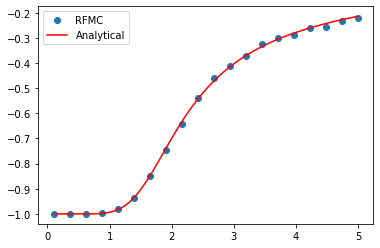

In [10]:
plt.plot(temperatures, energies,'o',label='RFMC')
import pandas as pd
data = pd.read_csv('4x4_Plaquette_Analytical_Solution.csv',sep='\t',header=None)
plt.plot(data[0],data[1],'r',label='Analytical')
z=plt.legend()